# Processing data for Facebook news experiment

This Jupyter notebook outputs processed data that when used with the notebook `FB_news_experiment.ipynb` reproduces the Facebook news experiments in Maghakian *et al.* __[[2023]](https://arxiv.org/abs/2211.15823)__. There are two output files: (1) `processed_data.csv` contains information about each post in the dataset; (2) `feedback_probs.pkl` contains information about the likelihood of seeing each type of feedback signal from readers given their satisfaction with the content.

## Details on Facebook dataset

The original __[Martinchek dataset](https://shift.newco.co/2016/11/09/What-I-Discovered-About-Trump-and-Clinton-From-Analyzing-4-Million-Facebook-Posts/)__ contains all posts made by top news pages on Facebook from 2012 to 2016, along with the total number of reactions for each post. The news pages include: (1) ABC News, (2) BBC News, (3) CBS News, (4) CNN, (5) Fox News, (6) The Huffington Post, (7) NBC News, (8) NPR, (9) The New York Times, (10) The Los Angeles Times, (11) TIME Magazine, (12) USA Today, (13) The Washington Post, (14) The Wall Street Journal. Each row of the original dataset included a post_id (this is preserved in our processed data set), information about the type of post, date of post, text information, total number of interactions for *comments*, *shares* and the six click-based reactions: *like*, *love*, *haha*, *wow*, *sad* and *angry*.<br>

<br>

<div>
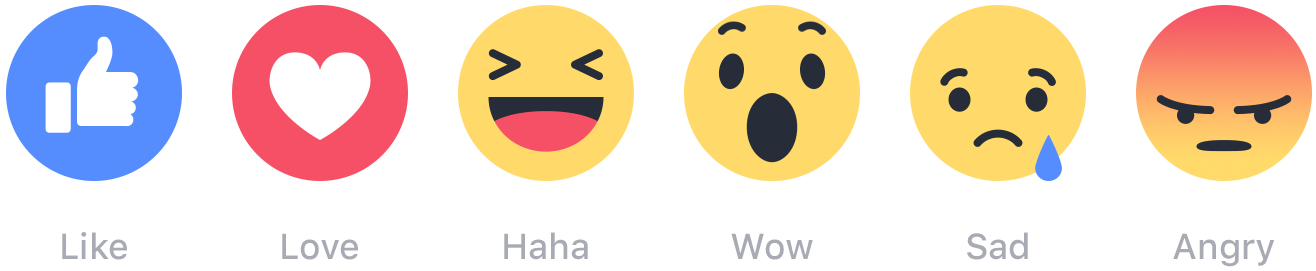
</div>

## Recovering latent mapping of feedback signals for each news source

Our simulation setup requires an underlying latent score ($r=-1$, $r=0$ or $r=1$) associated with each post as well as a probability distribution across feedback signals that depends on only the latent score and news source. The probability distribution is allowed to vary across news sources.

To generate the probability distributions, we compute a correlation matrix across feedback signals for each news source and then use PCA to obtain a low dimensional representation of the structure between different signals. We cluster the low dimensional embedding to determine which feedback signals are highly associated. To disambiguate the clusters we designate the cluster containing the *like* signal as $r=1$, the cluster containing the *angry* signal as $r=-1$ and the remaining cluster as $r=0$. For the probabilities of a user emitting a feedback signal given $r$, we use aggregate statistics for the chosen news source across 6 months of data. Finally, we introduce the 'none' signal for $r=0$ and assign it a probability of `r0_sparsity` to account for the fact that the vast majority of people do not interact with posts.

In [1]:
def get_latent_mapping_and_probs(news_sources,r0_sparsity):
    import pandas as pd
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    
    reactions = ['like','comment','share','love','wow','haha','sad','angry']

    latent_mapping = {}
    probs = {}

    for file in news_sources:
        latent_mapping[file] = {}

        df = pd.read_csv('facebook_posts/'+file+'.csv')
        df = df.rename(columns={'likes_count':'like', 'comments_count':'comment', 'shares_count':'share',
                                'love_count':'love', 'wow_count':'wow', 'haha_count':'haha',
                                'sad_count':'sad', 'angry_count':'angry'})
        df_corr = df[reactions].corr() # generate correlation matrix for reactions

        output_pca = PCA(n_components = 2).fit_transform(df_corr) # low dimensional mapping of correlation matrix
        kmeans = KMeans(n_clusters=3).fit(output_pca) # cluster reactions into 3 clusters (r=-1,r=0,r=1) 

        for ind in range(3): # disambiguate clusters by using 'like' and 'angry' as grounding
            cluster = [reactions[i] for i in range(len(reactions)) if kmeans.labels_[i]==ind]
            if 'like' in cluster:
                latent_mapping[file][1] = cluster
            elif 'angry' in cluster:
                latent_mapping[file][-1] = cluster
            else:
                latent_mapping[file][0] = cluster

        probs[file] = {}
        for key in latent_mapping[file].keys():
            freq = df[latent_mapping[file][key]].sum()/sum(df[latent_mapping[file][key]].sum()) # get frequency of each signal in specified cluster
            if key == 0:
                prob_list = [r0_sparsity] # r=0 state is only state where 'none' reaction occurs
            else:
                prob_list = [0]
            for reaction in reactions:
                if reaction in freq:
                    if key == 0: # scale frequency of reactions for r=0 relative to 'none' reaction
                        prob_list.append((1-r0_sparsity)*freq[reaction])
                    else:
                        prob_list.append(freq[reaction])
                else:
                    prob_list.append(0) 
            probs[file][key] = prob_list
    return latent_mapping, probs

## Generating latent rewards and action features associated with each post

For generating the latent scores associated with posts, we construct sets of posts generated on the same day. We assign the post with the highest positive engagement a score of $r=1$, the post with highest negative engagement a score of $r=-1$, and the remaining posts are assigned $r=0$. The action features for each post are generated using existing data such as type of post (*link*, *video*, *photo*, *status* or *event*) as well as features generated using the `paraphrase-MiniLM-L6-v2` model from the __[SentenceTransformers](https://www.sbert.net/)__ framework to summarize the text content of each post. This process generates a 389 dimensional vector respresentation of each post in the dataset.

In [2]:
def generate_processed_data(news_sources,nactions,r0_sparsity):
    import pandas as pd
    import numpy as np
    from sentence_transformers import SentenceTransformer, util
    
    latent_mapping, probs = get_latent_mapping_and_probs(news_sources,r0_sparsity)
    post_mapping = {'link':0,'video':1,'photo':2,'status':3,'event':4}
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    df_action_sets = pd.DataFrame()

    for file in news_sources:

        df = pd.read_csv('facebook_posts/'+file+'.csv')
        df = df.rename(columns={'likes_count':'like', 'comments_count':'comment', 'shares_count':'share',
                          'love_count':'love', 'wow_count':'wow', 'haha_count':'haha',
                          'sad_count':'sad', 'angry_count':'angry'})

        df['posted_at'] = pd.to_datetime(df['posted_at'])

        df['engagement'] = df[['like','comment','share','love','wow','haha','sad','angry']].sum(axis=1)
        df['latent_score'] = df[latent_mapping[file][1]].sum(axis=1)-df[latent_mapping[file][-1]].sum(axis=1)

        days = pd.unique(df['posted_at'].dt.date)
        act_set_idx = 0

        for day in days:
            df_day = df[df['posted_at'].dt.date==day]
            if len(df_day) > int(1.25*nactions):       
                df_daily = pd.concat([df_day.nlargest(1,['latent_score']),df_day.drop(df_day['latent_score'].idxmax()).nsmallest(nactions-1,['engagement'])])
                df_daily = df_daily.sort_values(by=['latent_score'])
                df_daily.reset_index(drop=True, inplace=True)
                df_daily['latent_reward'] = 0
                df_daily.at[0,'latent_reward'] = 1

                df_daily['post_id'] = df_daily['post_type'].apply(lambda x: np.identity(len(post_mapping))[post_mapping[x]])
                df_daily['text']=df_daily['name'].fillna('')+'. '+df_daily['message'].fillna('')+' '+df_daily['description'].fillna('')
                df_daily['action_feat'] = df_daily.apply(lambda x: np.concatenate((model.encode(x.text),x.post_id),axis=0), axis=1)


                df_daily.at[nactions-1,'latent_reward'] = -1
                df_daily['news_id'] = file
                df_daily['date'] = day
                df_daily['set_id'] = act_set_idx
                if len(df_daily) == nactions:
                    act_set_idx+=1
                    df_action_sets = pd.concat([df_action_sets, df_daily[['id','news_id','latent_reward','action_feat','date','set_id']]])
    valid_days = df_action_sets.groupby('date').count()['id'][df_action_sets.groupby('date').count()['id']==nactions*len(news_sources)].index
    df_action_sets = df_action_sets[df_action_sets['date'].isin(valid_days)]
    df_action_sets.reset_index(drop=True, inplace=True)
    
    return df_action_sets, probs

## Generate processed data

We generate the processed dataset using 6 months of data, with 10 posts per day for each news source, and a sparsity setting of `r0_sparsity=0.9` (when users are indifferent to content, we assume they do not engage with content 90% of the time).

In [3]:
def write_processed_data(data,probs,data_file_name,probs_file_name):
    import pickle
    
    data.to_csv(data_file_name+'.csv')
    with open(probs_file_name+'.pkl','wb') as f:
        pickle.dump(probs,f)

In [4]:
all_sources = ['abc','bbc','cbs','cnn','fox','huffpost','la-times',
               'nbc','npr','nyt','time','usatoday','washpost','wsj']

n_posts = 10 # number posts from each day
sparsity_rate = 0.9 # frequency with which uninterested users do not engage with news posts

data, probs = generate_processed_data(all_sources,n_posts,sparsity_rate)
write_processed_data(data,probs,'processed_data','feedback_probs')